In [1]:
from typing import Dict
from pathlib import Path
from text2sql_lib.result_metrics import LLMResultMetrics
from complexity_map import complexity_map
# ---------------------------------------------------------------------------
# create one metrics object per file
# ---------------------------------------------------------------------------
BENCH_DIR           = Path("better_benchmarks")
_SUFFIX             = ".jsonl"                 # all files end with this
metrics: Dict[str, LLMResultMetrics] = {}

for json_file in sorted(BENCH_DIR.glob(f"*{_SUFFIX}")):
    model_name  = json_file.stem                         # e.g. deepseek-r1-14b
    var_name    = model_name.replace("-", "_").replace(".", "_")           # python-valid identifier
    m           = LLMResultMetrics.from_jsonl(
        json_file,
        model_name=model_name,
        complexity_map=complexity_map,
    )
    metrics[var_name] = m
    globals()[var_name] = m     # optional: create variable in global scope

metrics["gpt_4_1"].open_source=False
metrics["gpt_4_1_mini"].open_source=False
metrics["gpt_4_1_nano"].open_source=False
metrics["o3"].open_source=False
metrics["o3"].reasoning=True
metrics["o3_mini"].open_source=False
metrics["o3_mini"].reasoning=True
metrics["o4_mini"].open_source=False
metrics["o4_mini"].reasoning=True
metrics["qwen3_14b"].reasoning=True
metrics["deepseek_r1_14b"].reasoning=True
metrics["qwen3_30b_a3b"].reasoning=True

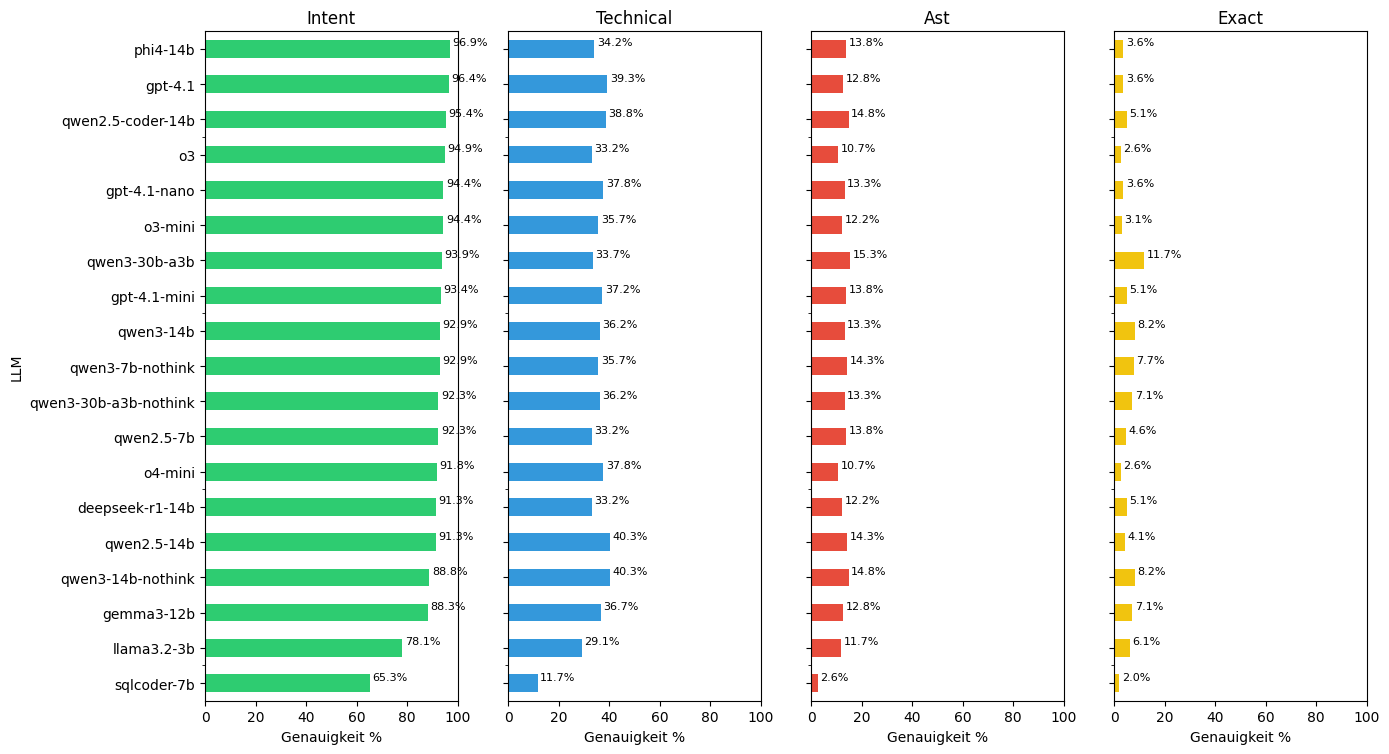

In [2]:
from text2sql_lib.viz_toolbox import *

plot_overall_multi(metrics)

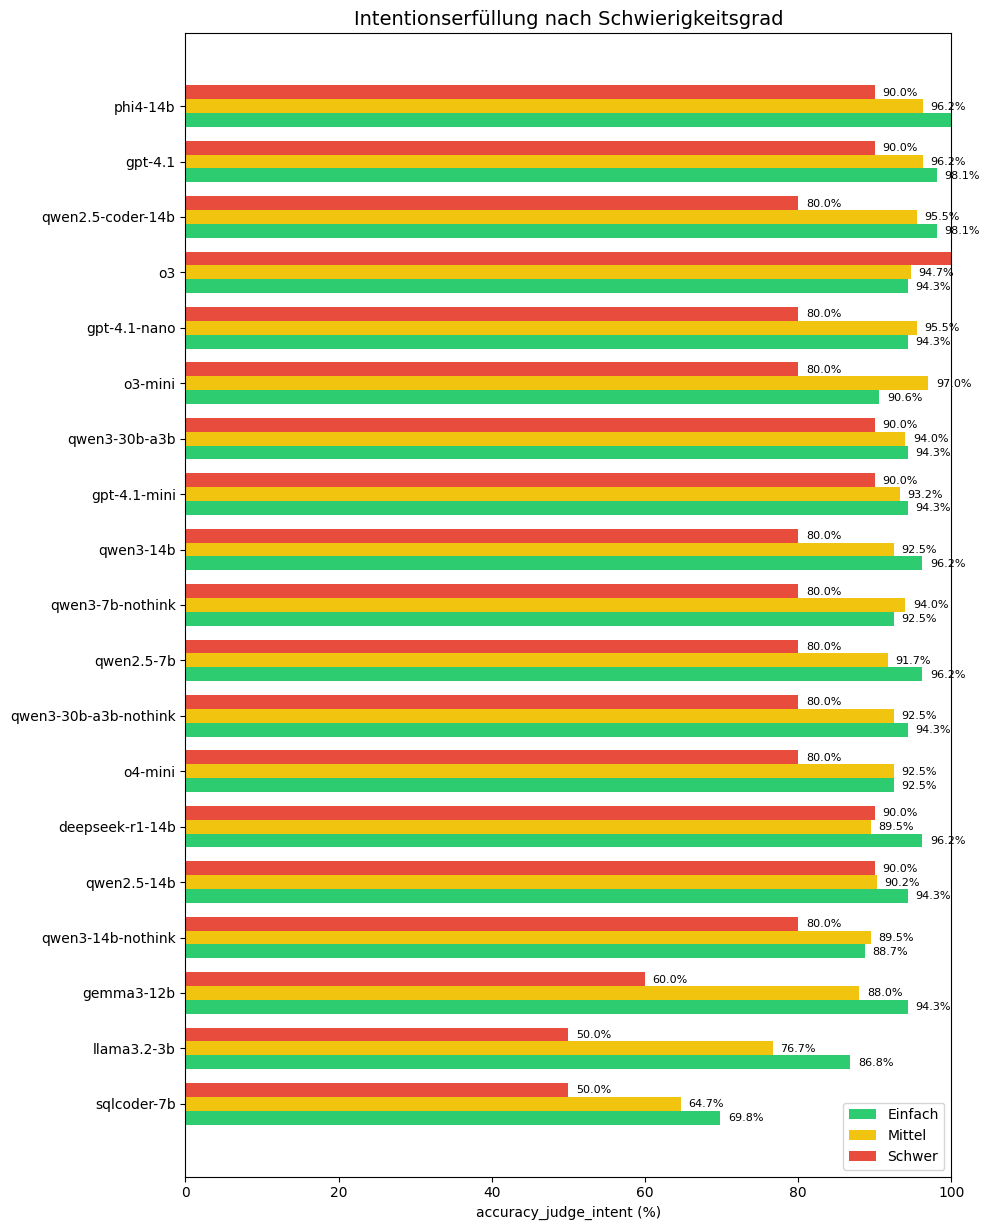

In [3]:
plot_difficulty_grouped(metrics, metric_fn_name="accuracy_judge_intent")

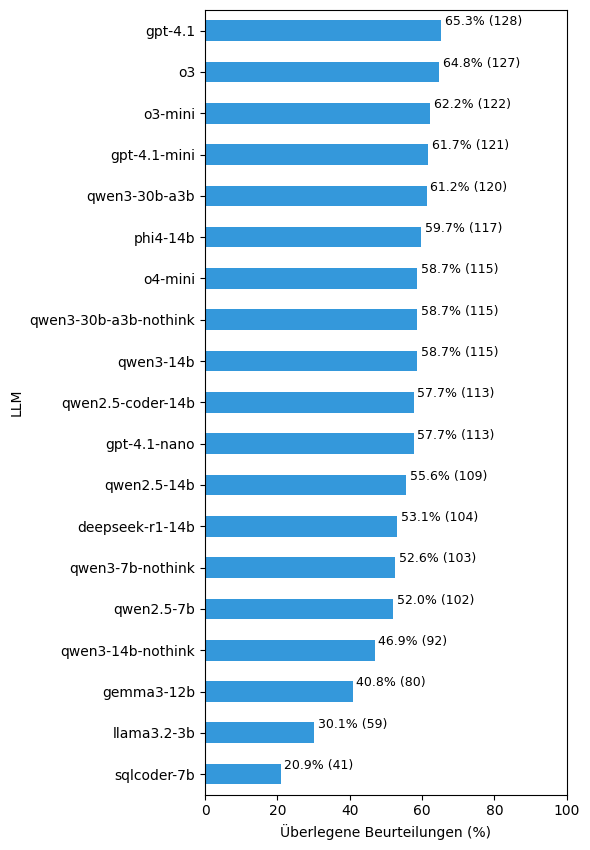

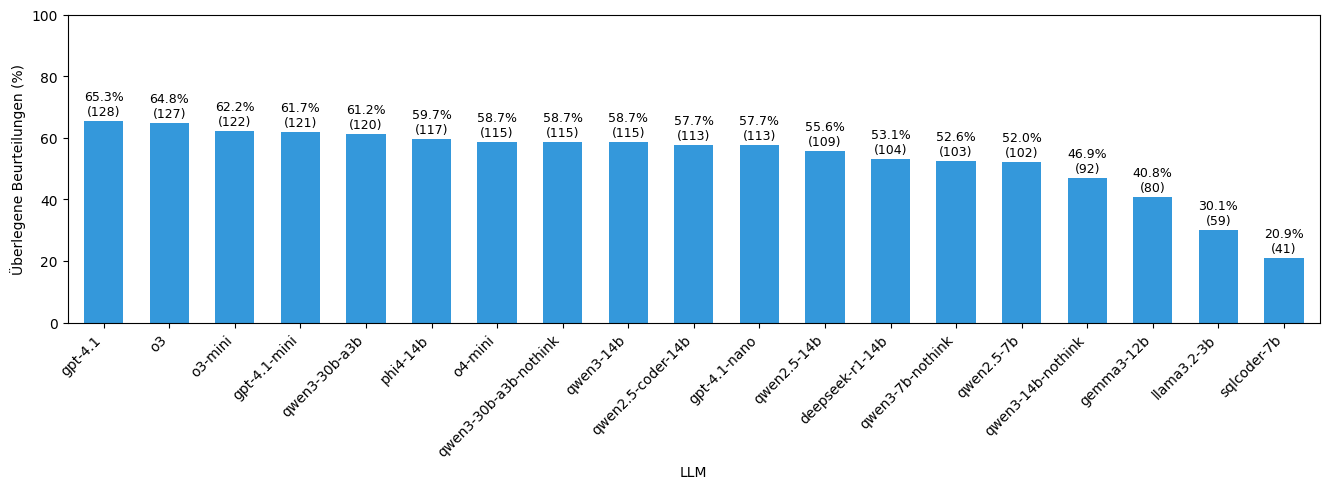

In [4]:
plot_superior(metrics, show_counts=True)
plot_superior_horizontal(metrics, show_counts=True)

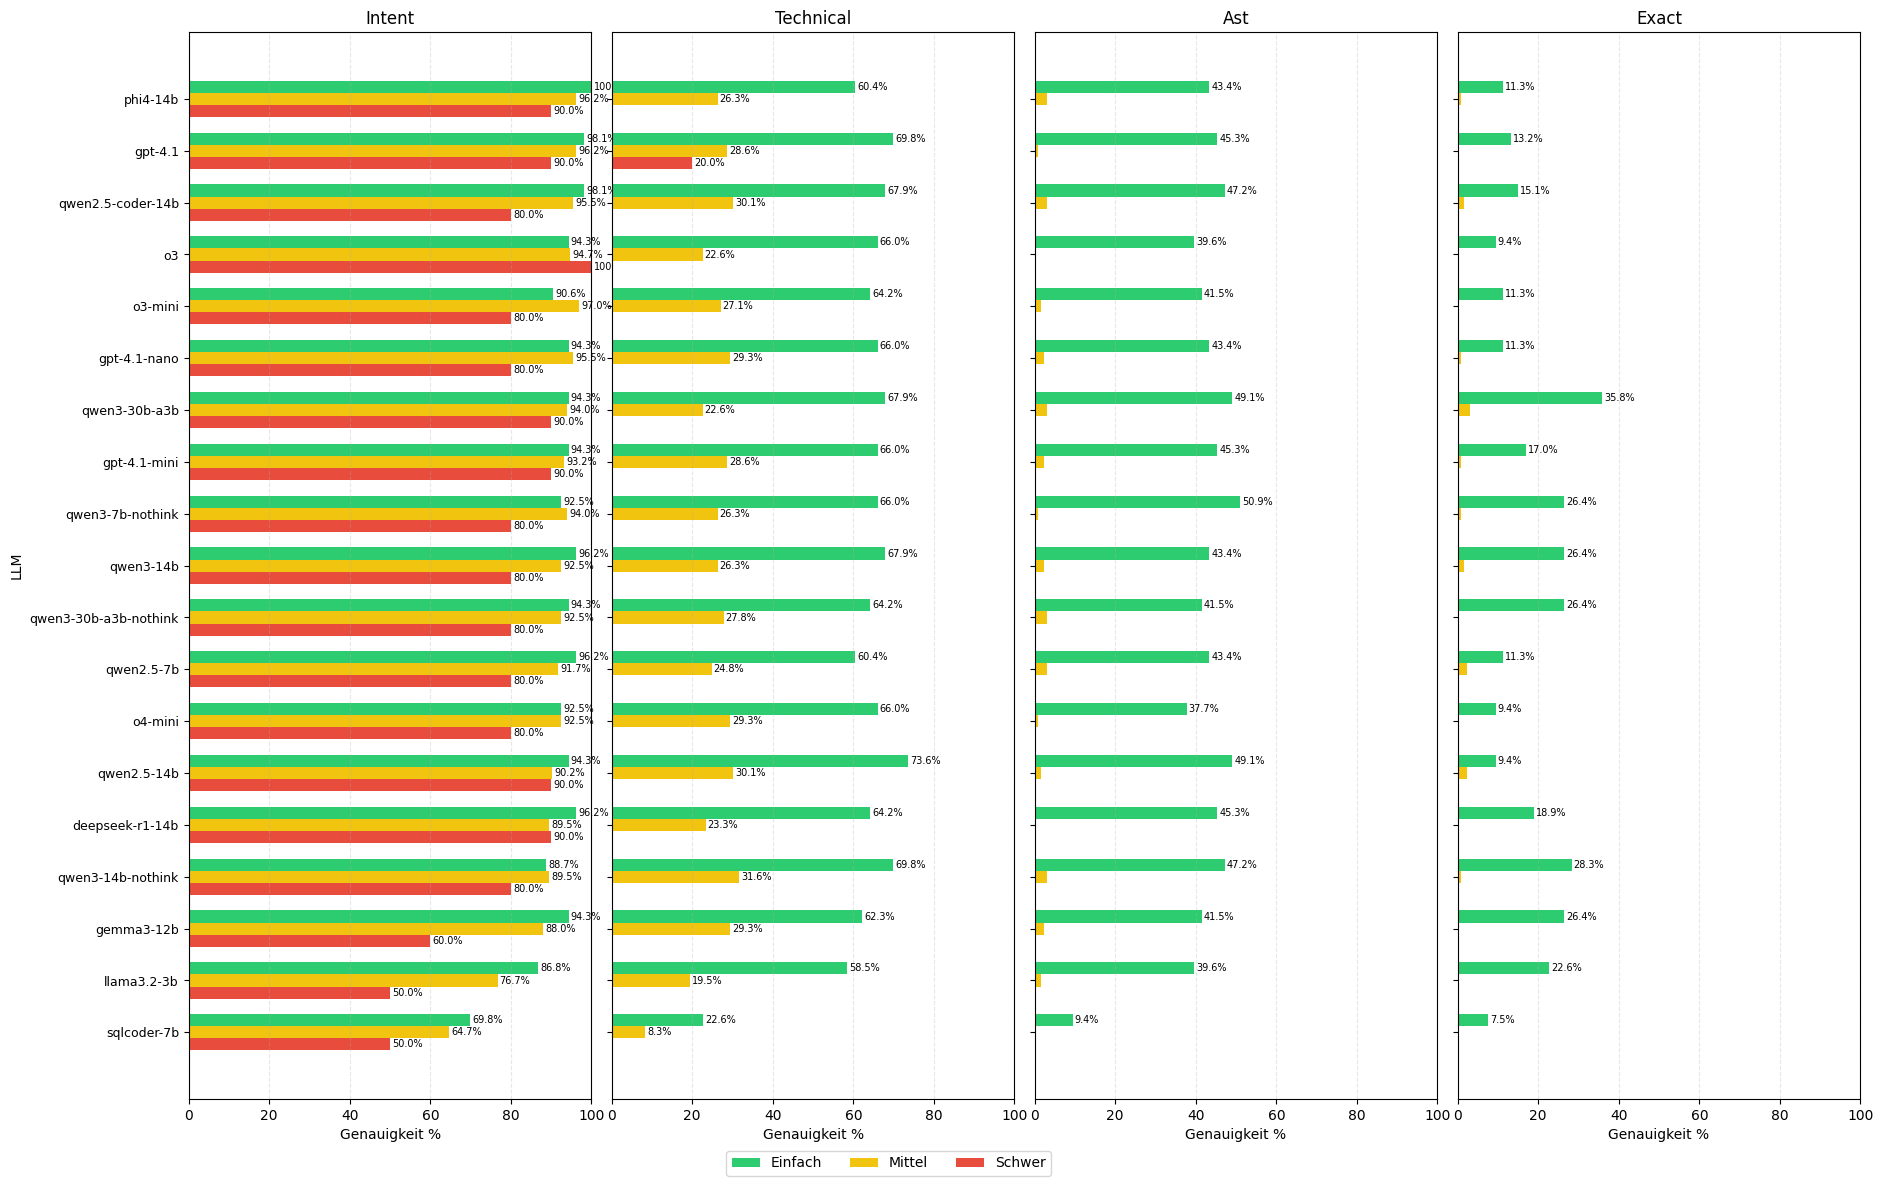

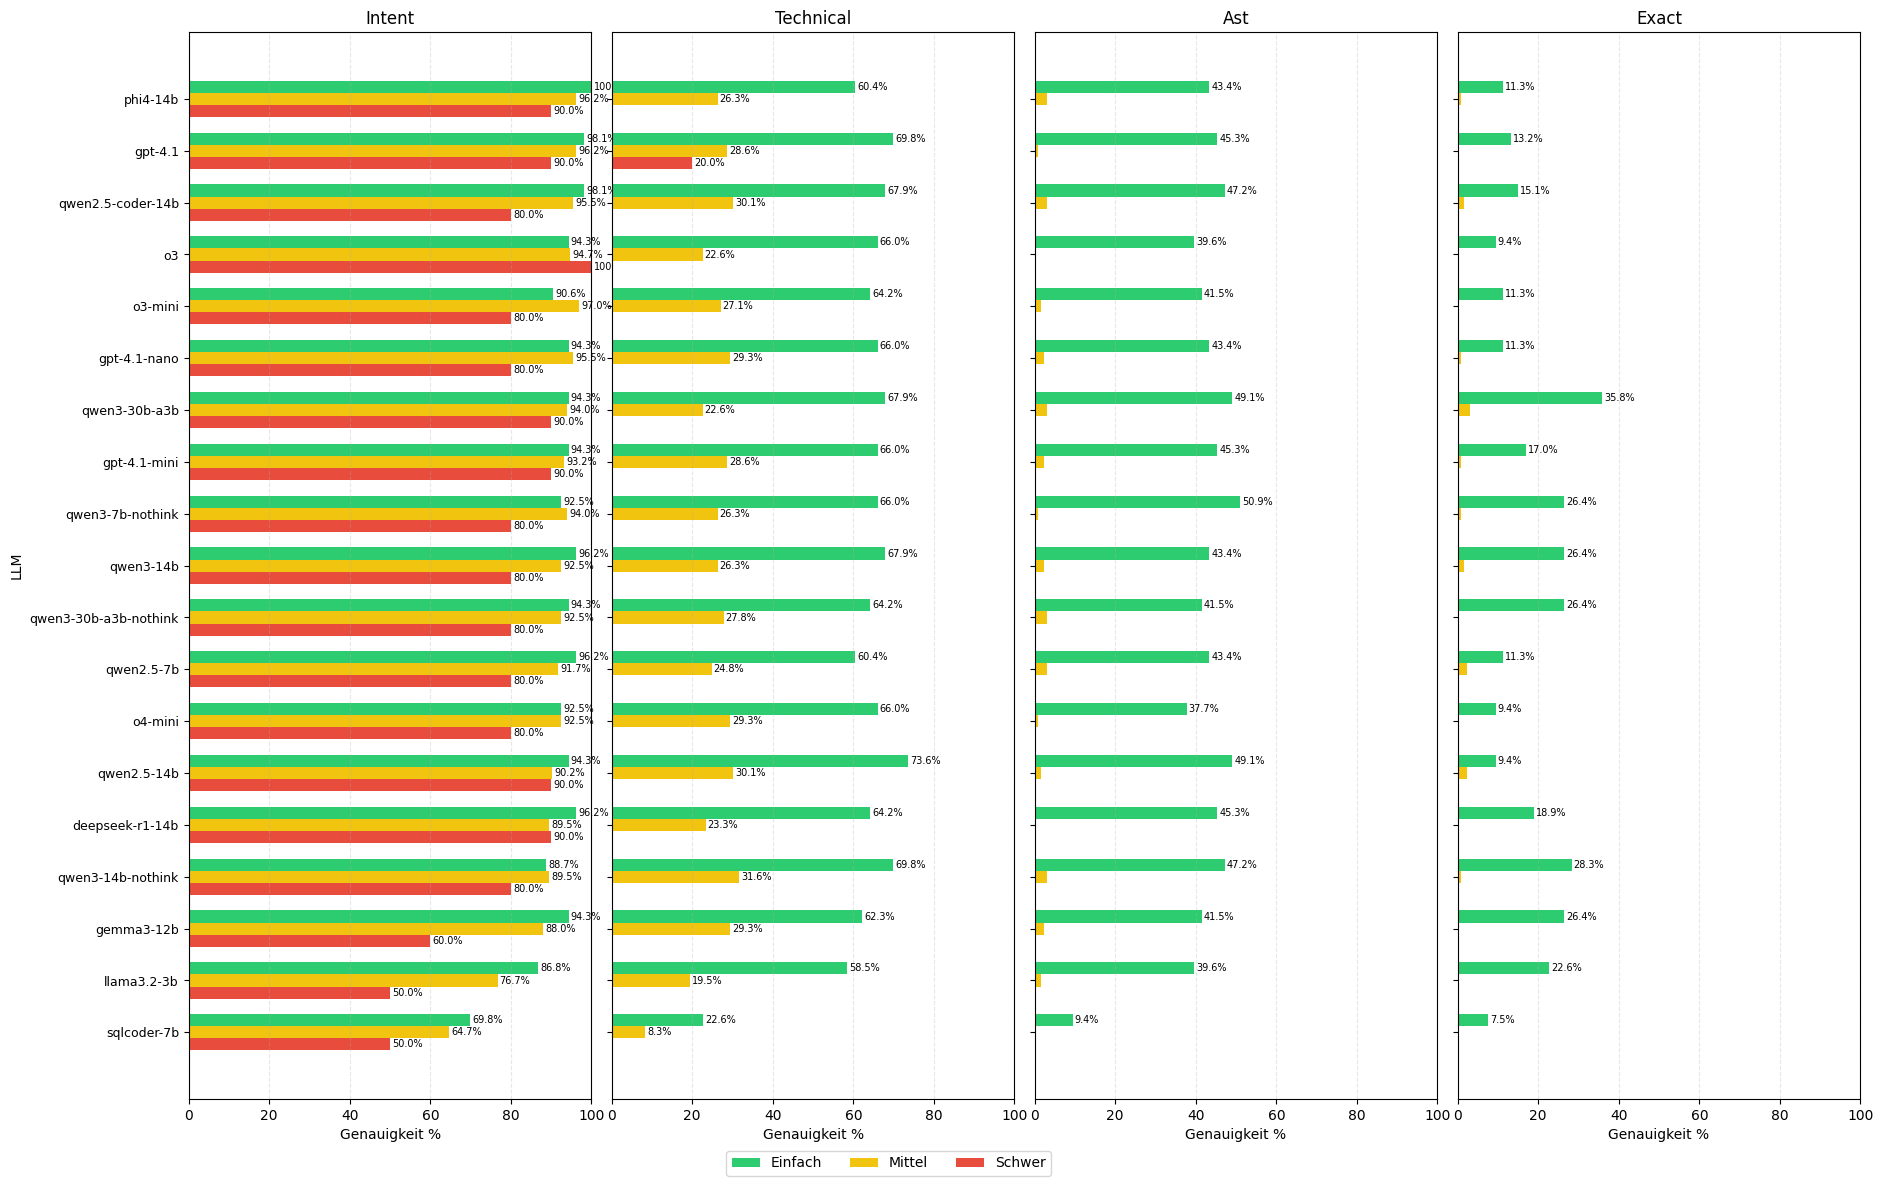

In [5]:
# import matplotlib.pyplot as plt
# import numpy as np
# from typing import Dict

# def plot_all_metrics_horizontal_grouped(metrics_dict: Dict[str, "LLMResultMetrics"]) -> None:
#     """
#     Erstellt einen Plot mit 4 nebeneinander angeordneten Subplots für alle Metriken,
#     wobei jeder Balken nach Schwierigkeitsgraden (easy, medium, hard) aufgeteilt ist.
#     """
#     # Metriken in der gewünschten Reihenfolge
#     metrics_order = [
#         "accuracy_judge_intent",
#         "accuracy_judge_technical", 
#         "accuracy_ast", 
#         "accuracy_exact"
#     ]
    
#     # Kurze Titel für die Metriken
#     metric_titles = {
#         "accuracy_judge_intent": "Intent",
#         "accuracy_judge_technical": "Technical",
#         "accuracy_ast": "Ast",
#         "accuracy_exact": "Exact"
#     }
    
#     COLOR_SCHEME = {
#         "intent": "#2ecc71",    # Grün
#         "technical": "#3498db", # Blau
#         "ast": "#e74c3c",       # Rot
#         "exact": "#f1c40f",     # Gelb
#         "easy": "#2ecc71",      # Grün
#         "medium": "#f1c40f",    # Gelb
#         "hard": "#e74c3c",      # Rot
#     }
    
#     # Sammle alle Modellnamen und sortiere nach Intent-Metrik
#     all_models = []
#     for name, m in metrics_dict.items():
#         intent_fn = getattr(m, "accuracy_judge_intent")
#         all_models.append((m.model_name, intent_fn()))
    
#     # Sortiere Modelle nach Intent-Genauigkeit (absteigend)
#     all_models.sort(key=lambda x: x[1], reverse=True)
#     model_order = [m[0] for m in all_models]
    
#     # Figur erstellen - mehr Platz für die Modellnamen
#     fig, axes = plt.subplots(1, 4, figsize=(20, 12), sharey=True)
    
#     # Y-Position für alle Modelle
#     y_pos = np.arange(len(model_order))
    
#     # Für jede Metrik einen Subplot erstellen
#     for i, metric_fn_name in enumerate(metrics_order):
#         ax = axes[i]
        
#         # Daten für easy, medium und hard sammeln
#         easy_values = []
#         medium_values = []
#         hard_values = []
        
#         for model_name in model_order:
#             m = next(m for name, m in metrics_dict.items() if m.model_name == model_name)
#             fn = getattr(m, metric_fn_name)
#             easy_values.append(fn("easy") * 100)
#             medium_values.append(fn("medium") * 100)
#             hard_values.append(fn("hard") * 100)
        
#         # Balken für jeden Schwierigkeitsgrad zeichnen
#         bar_height = 0.7
#         small_bar_height = bar_height / 3
        
#         # Hard (unten)
#         hard_bars = ax.barh(y_pos - small_bar_height, hard_values, 
#                            color=COLOR_SCHEME["hard"], 
#                            height=small_bar_height, 
#                            label="Schwer")
        
#         # Medium (mitte)
#         medium_bars = ax.barh(y_pos, medium_values, 
#                              color=COLOR_SCHEME["medium"], 
#                              height=small_bar_height, 
#                              label="Mittel")
        
#         # Easy (oben)
#         easy_bars = ax.barh(y_pos + small_bar_height, easy_values, 
#                            color=COLOR_SCHEME["easy"], 
#                            height=small_bar_height, 
#                            label="Einfach")
        
#         # Werte an den Balken anzeigen - nur wenn sie größer als ein Schwellwert sind
#         threshold = 5.0  # Nur Werte > 5% anzeigen
        
#         for j in range(len(y_pos)):
#             # Hard
#             if hard_values[j] > threshold:
#                 ax.text(hard_values[j] + 0.5, y_pos[j] - small_bar_height, 
#                        f"{hard_values[j]:.1f}%", va='center', fontsize=7)
#             # Medium
#             if medium_values[j] > threshold:
#                 ax.text(medium_values[j] + 0.5, y_pos[j], 
#                        f"{medium_values[j]:.1f}%", va='center', fontsize=7)
#             # Easy
#             if easy_values[j] > threshold:
#                 ax.text(easy_values[j] + 0.5, y_pos[j] + small_bar_height, 
#                        f"{easy_values[j]:.1f}%", va='center', fontsize=7)
        
#         # Achsen & Beschriftungen
#         ax.set_title(metric_titles[metric_fn_name], fontsize=12)
#         ax.set_xlim(0, 100)
#         ax.set_xlabel("Genauigkeit %", fontsize=10)
        
#         # Gitter nur für x-Achse
#         ax.grid(axis='x', linestyle='--', alpha=0.3)
        
#         # # Y-Achsenbeschriftung nur beim ersten Subplot
#         # if i == 0:
#         #     ax.set_yticks(y_pos)
#         #     # Mehr Platz für die Modellnamen
#         #     plt.subplots_adjust(left=0.15)  # Mehr Platz links
#         #     ax.set_yticklabels(model_order, fontsize=9)
#         #     ax.set_ylabel("LLM", fontsize=10)
#         # else:
#         #     ax.set_yticks(y_pos)
#         #     ax.set_yticklabels([])
#         if i == 0:
#             ax.set_yticks(y_pos)
#             ax.set_yticklabels(model_order, fontsize=9)
#             ax.set_ylabel("LLM", fontsize=10)
#         else:
#             # keine Änderung an den (geteilten) Labels vornehmen!
#             ax.tick_params(axis="y", labelleft=False)   # nur ausblenden
    
#     # Gemeinsame Legende unten
#     fig.legend(
#         [easy_bars, medium_bars, hard_bars],
#         ["Einfach", "Mittel", "Schwer"],
#         loc='lower center',
#         ncol=3,
#         bbox_to_anchor=(0.5, 0.01),
#         fontsize=10
#     )
    
#     plt.tight_layout()
#     plt.subplots_adjust(wspace=0.05, bottom=0.08, left=0.15)
    
#     return fig

# # Beispielaufruf:
# # fig = plot_all_metrics_horizontal_grouped(metrics_dict)
# # plt.show()
plot_all_metrics_horizontal_grouped(metrics)

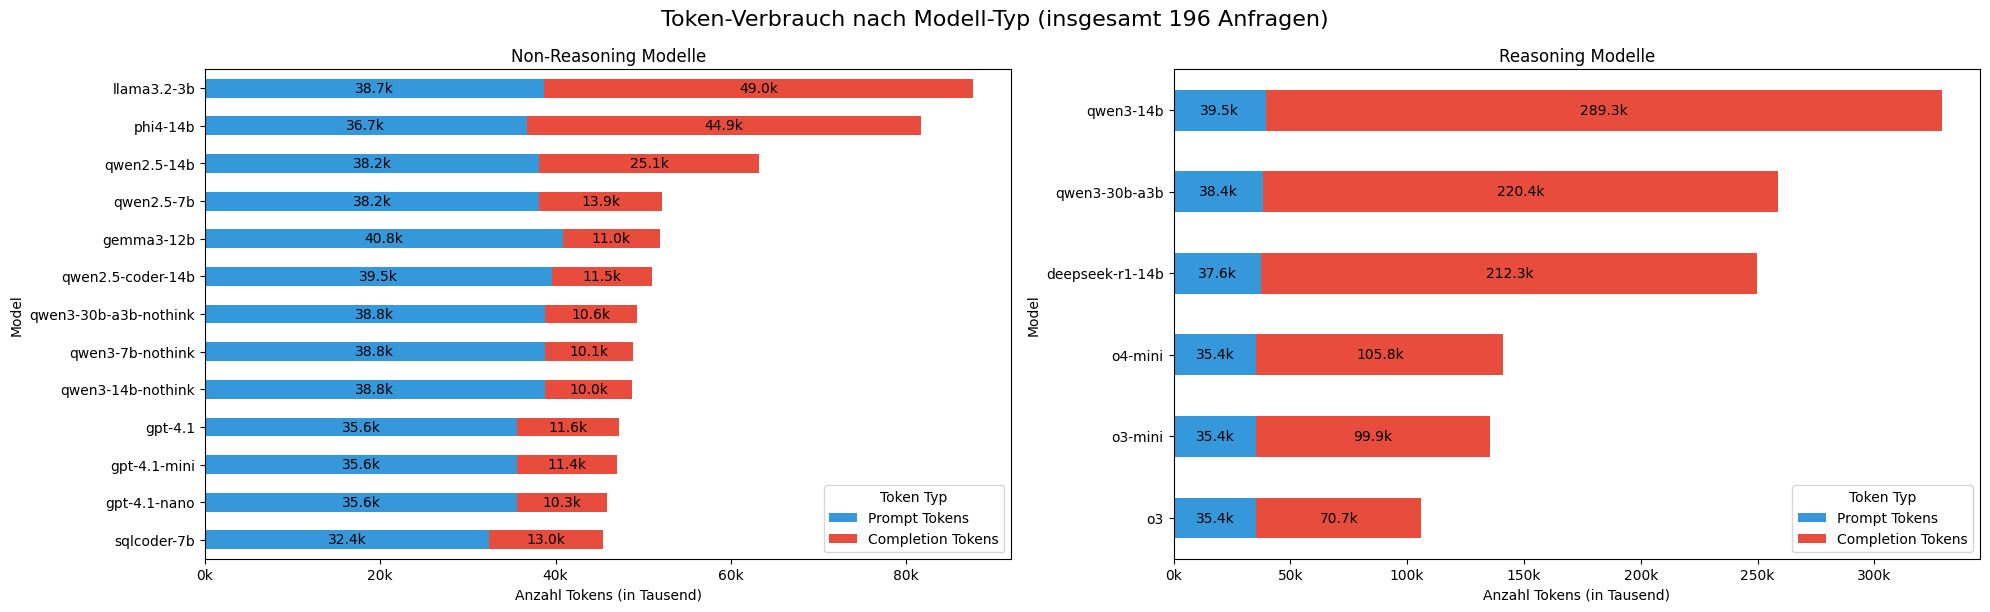

In [6]:
plot_token_usage(metrics)

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


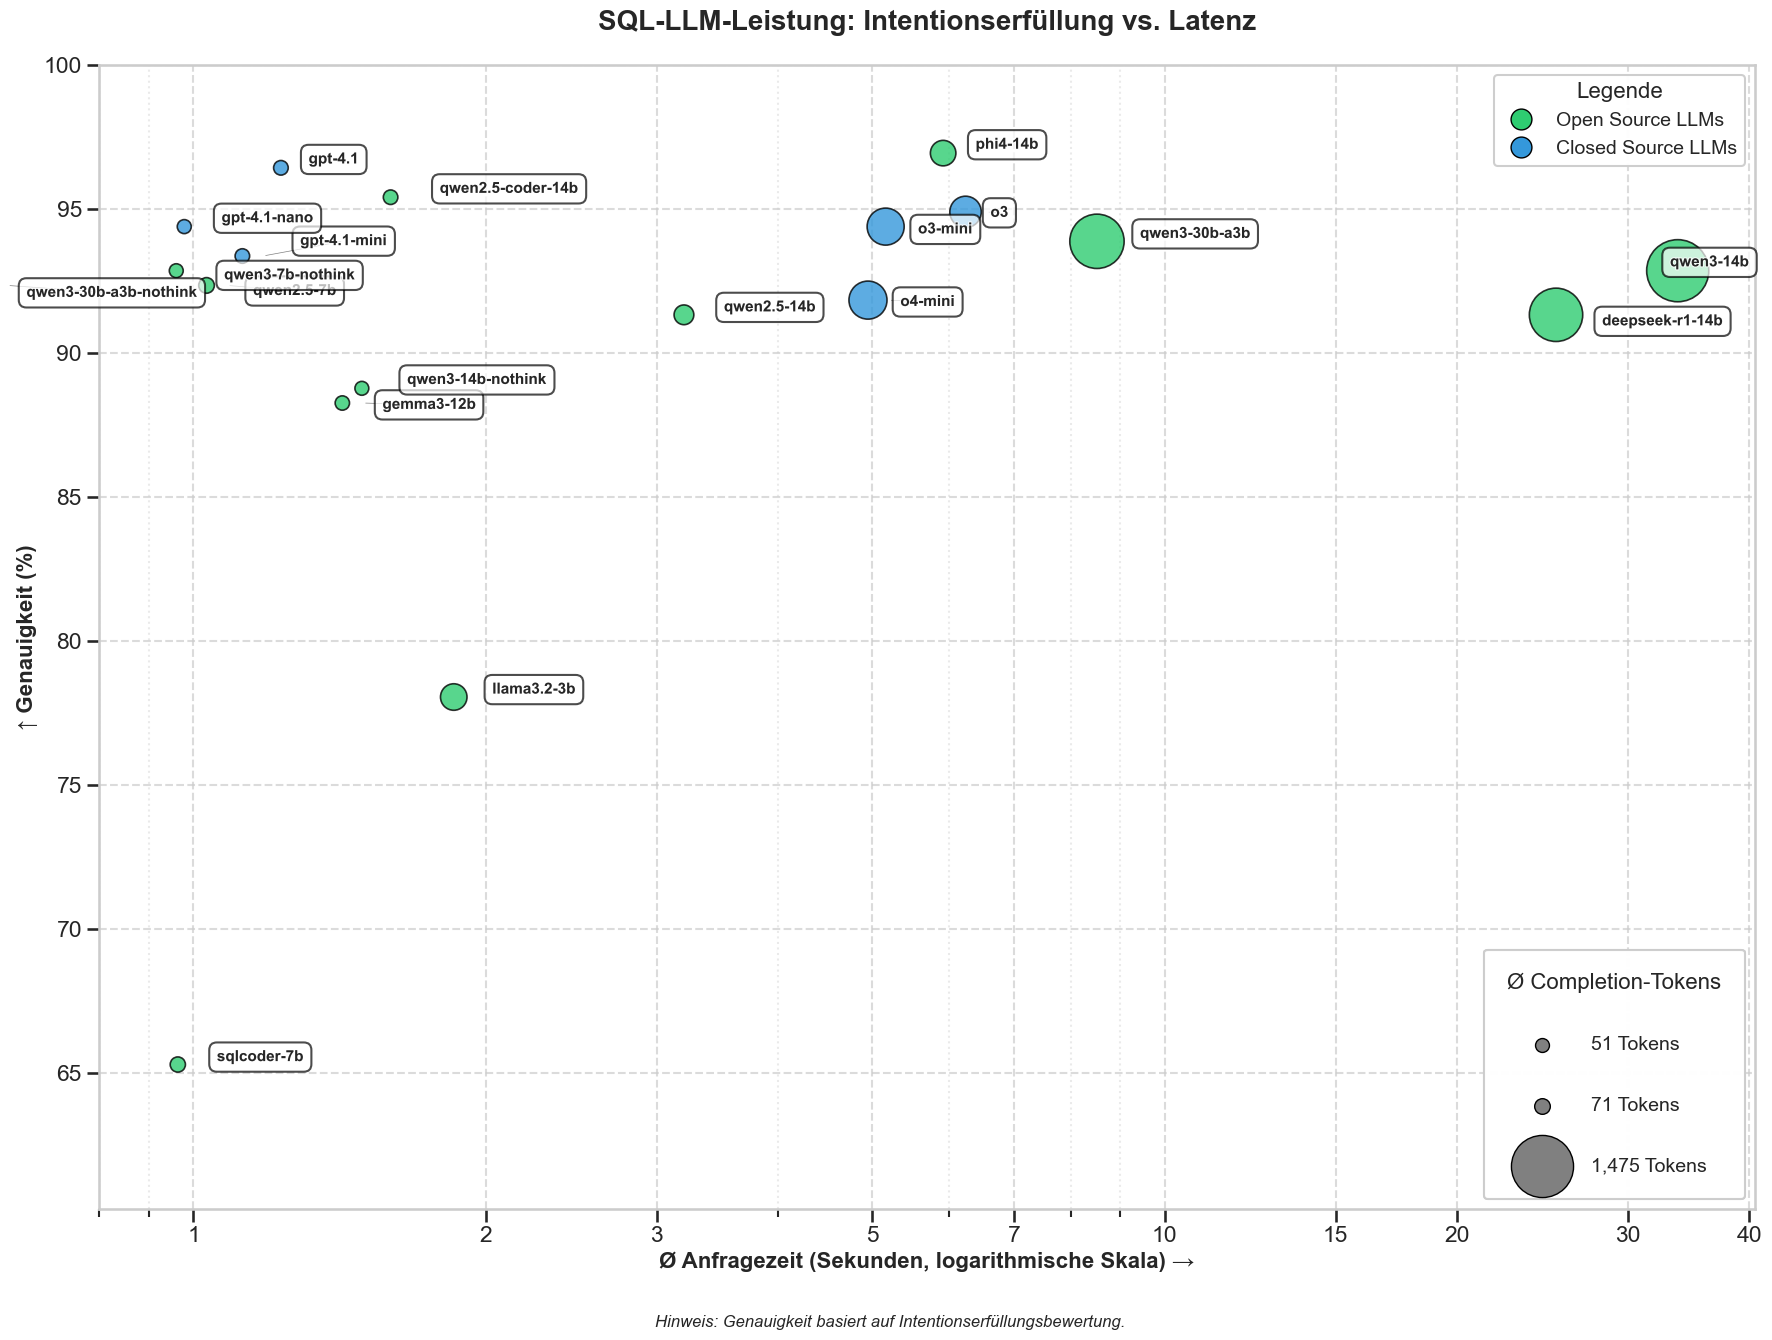

In [7]:
plot_model_comparison(metrics, accuracy_metric='intent',)

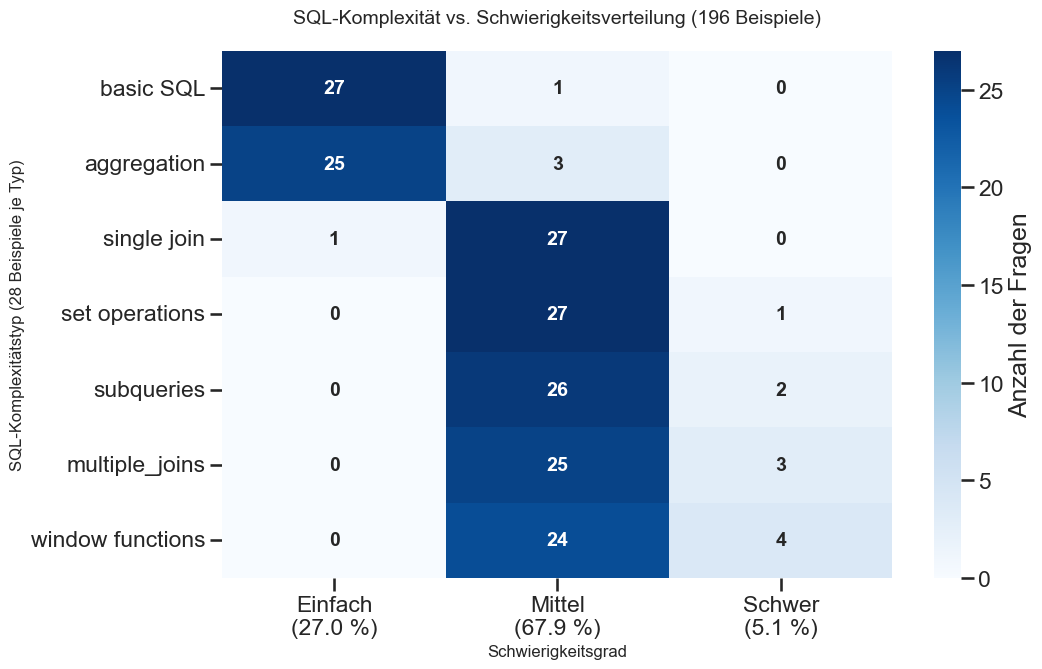

In [8]:
plot_complexity_heatmap(metrics, complexity_map)

/Users/daniel/projects/text2sql_eval/text2sql_lib/viz_toolbox.py:1550: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(left=0.0, right=max_time)


(<Figure size 1800x1400 with 1 Axes>,
 <Axes: title={'center': 'SQL Modell Performance Vergleich: Exact Accuracy vs. Latenz'}, xlabel='Ø Latenz (Sekunden, Log Skala)', ylabel='Accuracy (%)'>)

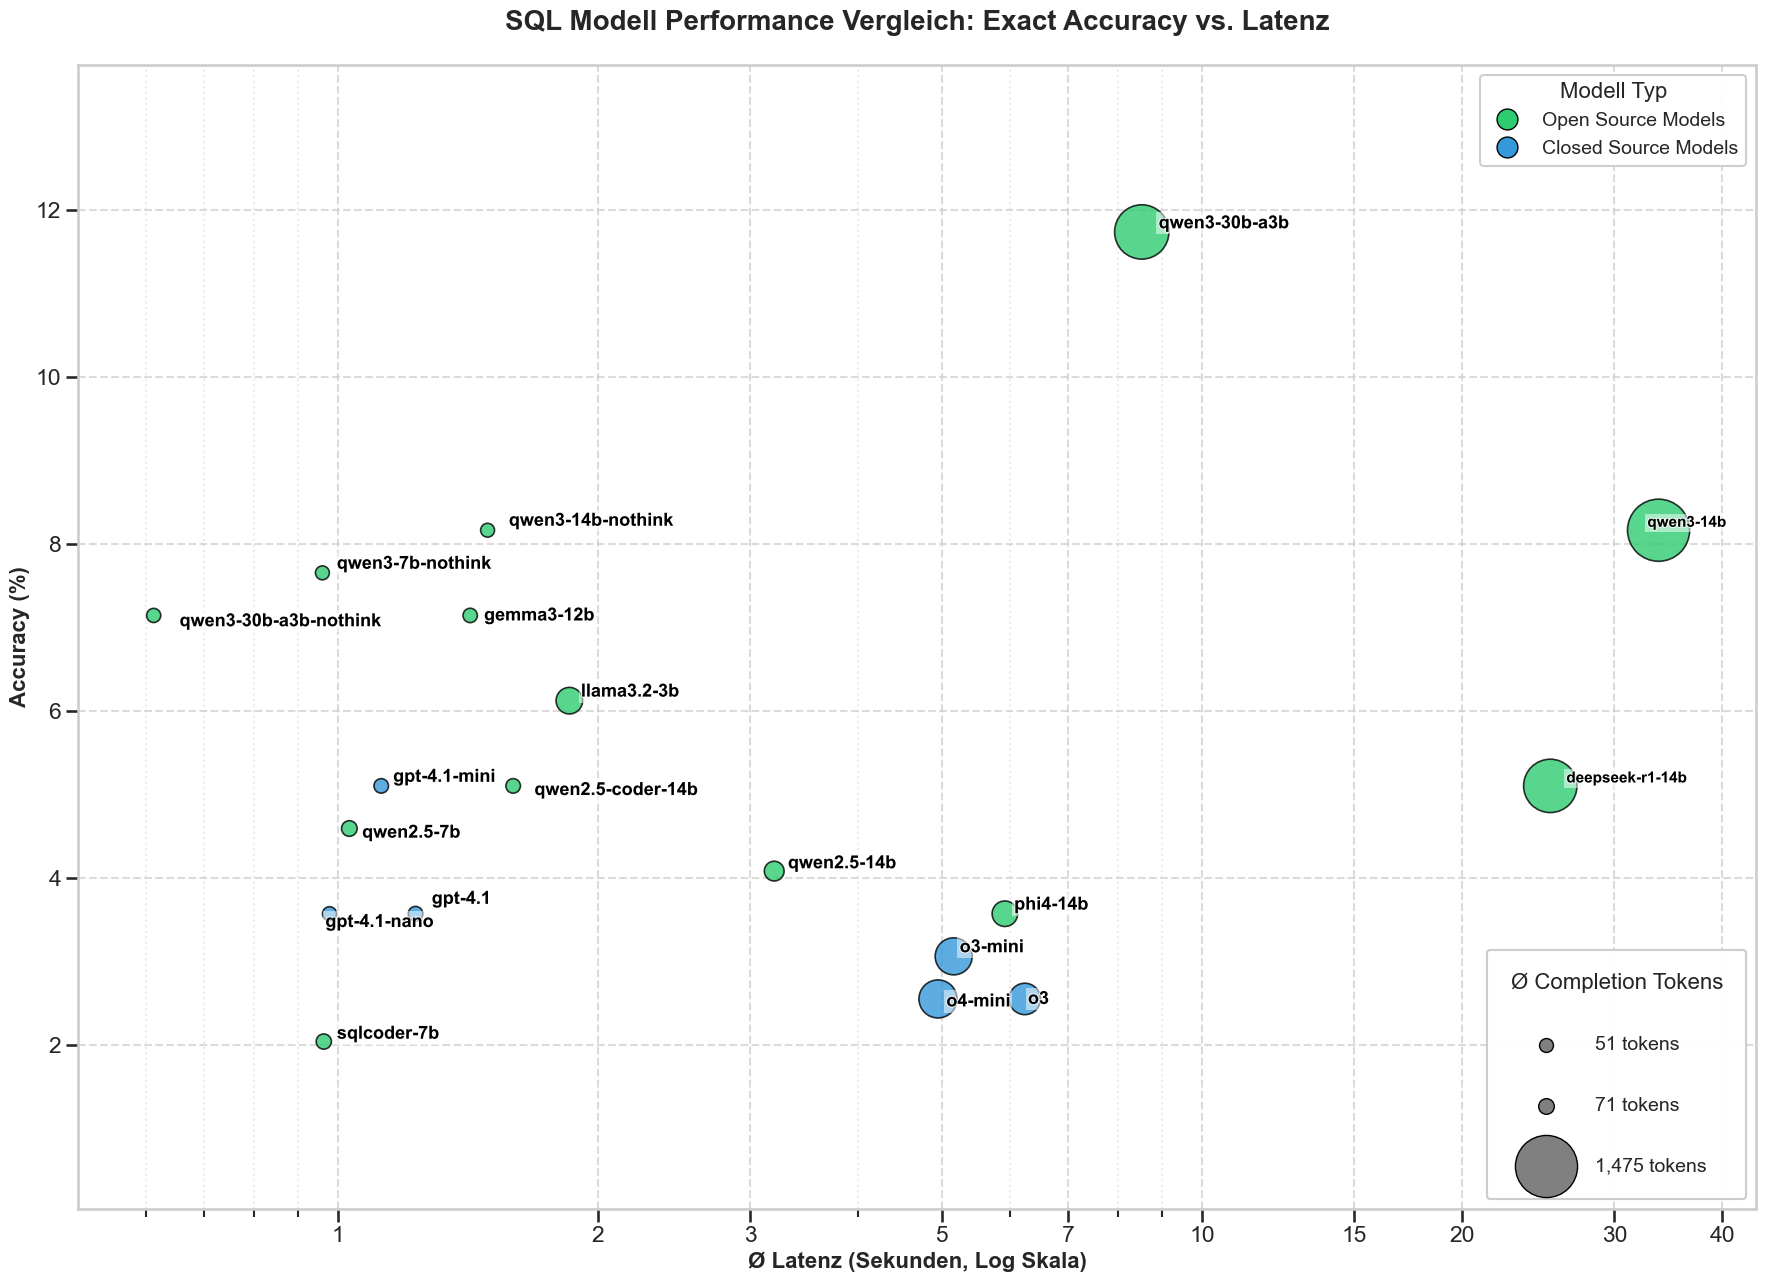

In [9]:
create_model_comparison_chart(metrics, accuracy_metric='Exact')

/Users/daniel/projects/text2sql_eval/text2sql_lib/viz_toolbox.py:1550: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(left=0.0, right=max_time)


(<Figure size 1800x1400 with 1 Axes>,
 <Axes: title={'center': 'SQL Modell Performance Vergleich: Intent Accuracy vs. Latenz'}, xlabel='Ø Latenz (Sekunden, Log Skala)', ylabel='Accuracy (%)'>)

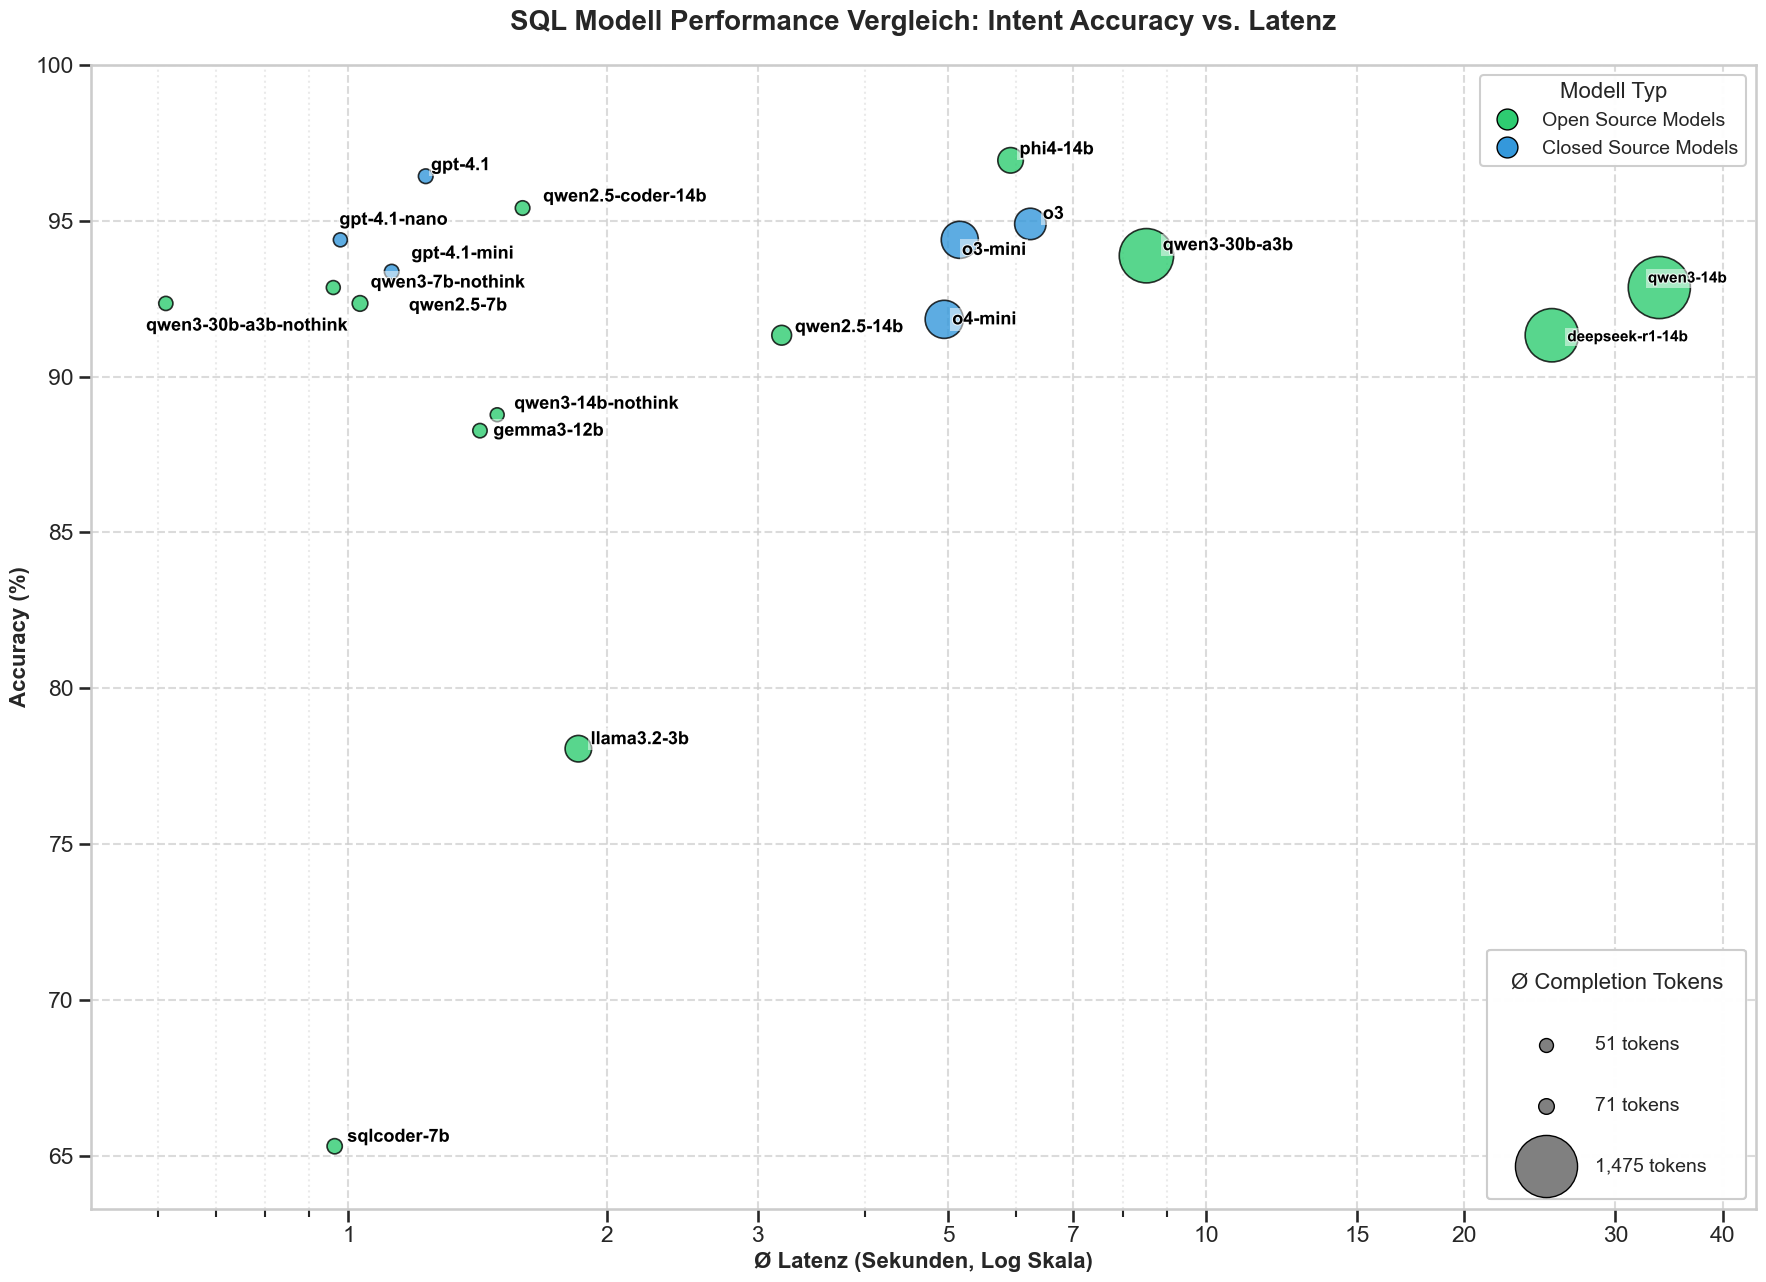

In [13]:
create_model_comparison_chart(metrics, accuracy_metric='intent')